In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [3]:
#load in the OD matrix for POI and bus stops extracted from GIS
fp_dest100 = "OD_allPOI_100.csv"
fp_dest300 = "OD_allPOI_300.csv"
fp_dest500 = "OD_allPOI_500.csv"
fp_dest400 = "OD_allPOI_400.csv"
fp_dest200 = "OD_allPOI_200.csv"
fp_dest600 = "OD_allPOI_600.csv"
fp_trips = "trips.csv"

In [4]:
df_DestBus100 = pd.read_csv(fp_dest100)
df_DestBus300 = pd.read_csv(fp_dest300)
df_DestBus500 = pd.read_csv(fp_dest500)
df_DestBus200 = pd.read_csv(fp_dest200)
df_DestBus400 = pd.read_csv(fp_dest400)
df_DestBus600 = pd.read_csv(fp_dest600)
df_trips = pd.read_csv(fp_trips)

In [5]:
df_DestBus100.dest_busid = df_DestBus100.dest_busid.astype(str)
df_DestBus200.dest_busid = df_DestBus200.dest_busid.astype(str)
df_DestBus300.dest_busid = df_DestBus300.dest_busid.astype(str)
df_DestBus400.dest_busid = df_DestBus400.dest_busid.astype(str)
df_DestBus500.dest_busid = df_DestBus500.dest_busid.astype(str)
df_DestBus600.dest_busid = df_DestBus600.dest_busid.astype(str)
df_trips.dest_busid = df_trips.dest_busid.astype(str)

In [6]:
df_trips = df_trips[df_trips['TripsPerDest']<1000].copy()

In [ ]:
len(df_trips)

In [8]:
def dest_summary_table (df_DestBus, df_trips, out_name):
    
    '''
    Generate the accessibility score table by first calculating the access scores for the bus stops and 
    their POI and then merging with the trips data
    Requires three inputs
    1. A dataframe containing the bus stops (dest_busid) and their distance (Total_Leng) to POIs (poi). 
    2. A trip table dataframe containing the exit bus stops (dest_busid), origin bus stops (orig_busid) and 
    the person trip ID (Card_Number)
    3. An appended string name that is used to identify the different distance buffer. E.g '100' to generate
    a table for 100m buffer 
    
    The function returns a dataframe containing access scores per bus stop, total number of destination trips,
    origin trips and pois per bus stop and average distance per bus stop
    
    '''

    
    #rename to show that the length is the raw length from GIS in meters
    df_DestBus.rename(columns={'Total_Leng':'raw_length'}, inplace = True)

    #there was infinity in the value and because of these two zero POI
    #print(df_DestBus[df_DestBus['raw_length']==0])

    df_DestBus = df_DestBus[df_DestBus['raw_length']!=0].copy()

    #df_DestBus['length'] = 1/((df_DestBus['raw_length'])**2)
    
    # set a beta value (b) based on f(x) = Ke^-bx K is 1 f(0) = k, for beta value use f(600) as the max dist
    beta = round ((np.log(0.001)/-600), 4)
    
    #apply distance decay for an accessibility score

    df_DestBus['length'] = df_DestBus['raw_length'].map(lambda x: math.exp(-beta * x))
    
    #get average length per bus stop
    dest_dist = df_DestBus.groupby('dest_busid')['raw_length'].mean().reset_index().rename(columns={'raw_length':'avg_distance'})

    #using sum
    dest_access = df_DestBus.groupby('dest_busid')['length'].sum().reset_index().rename(columns={'length':'access_score'})

    #1 - group POIs by dest
    dest_poi = df_DestBus.groupby('dest_busid')['poi'].count().reset_index()

    #number of trips per dest
    #dest_trips = df_trips.groupby(['dest_busid'])['Card_Number'].count().reset_index().rename(columns={'Card_Number':'TripsPerdest'})
    
    #number of trips per orig
    #orig_trips = df_trips.groupby(['orig_busid'])['Card_Number'].count().reset_index().rename(columns={'orig_busid':'dest_busid','Card_Number':'TripsPerOrig'})

    
    # merge the aggregates which reflects the distinct trips per bus stop
    from functools import reduce
    #dfs = [dest_trips,orig_trips,dest_poi, dest_dist, dest_access]
    dfs = [df_trips,dest_poi, dest_dist, dest_access]
    dest_summary = reduce(lambda left,right: pd.merge(left,right,on='dest_busid', how='left'), dfs)

    dest_summary.dest_busid = dest_summary.dest_busid.astype(str)
    poi_name = 'poi'+ '_'+ out_name
    avg_dist_name = 'avg_distance'+ '_'+ out_name
    access_name = 'access_score'+ '_'+ out_name
    dest_summary.rename(columns={'poi':poi_name, 'avg_distance':avg_dist_name,
       'access_score':access_name}, inplace=True)
    
    return dest_summary

In [9]:
dest100_summary = dest_summary_table (df_DestBus100, df_trips, '100')
dest200_summary = dest_summary_table (df_DestBus200, df_trips, '200')
dest300_summary = dest_summary_table (df_DestBus300, df_trips, '300')
dest400_summary = dest_summary_table (df_DestBus400, df_trips, '400')
dest500_summary = dest_summary_table (df_DestBus500, df_trips, '500')
dest600_summary = dest_summary_table (df_DestBus600, df_trips, '600')

In [10]:
def csv_save (name, file):
    output = name
    file.to_csv(output, index=False)

In [11]:
#output file for regression analysis
#csv_save('dest100_summary_single.csv',dest100_summary)
#csv_save('dest200_summary_single.csv',dest200_summary)
#csv_save('dest300_summary_single.csv',dest300_summary)
#csv_save('dest400_summary_single.csv',dest400_summary)
#csv_save('dest500_summary_single.csv',dest500_summary)
#csv_save('dest600_summary_single.csv',dest600_summary)

In [41]:
#merge all the distance buffer access dataframes for better descriptive analysis
from functools import reduce
dfs = [dest100_summary,dest200_summary,dest300_summary,dest400_summary,dest500_summary,dest600_summary]
dest_summary = reduce(lambda left,right: pd.merge(left,right,on='dest_busid', how='left'), dfs)

In [42]:
dest_summary.columns

Index(['dest_busid', 'TripsPerDest_x', 'TripsPerOrig_x', 'poi_100',
       'avg_distance_100', 'access_score_100', 'TripsPerDest_y',
       'TripsPerOrig_y', 'poi_200', 'avg_distance_200', 'access_score_200',
       'TripsPerDest_x', 'TripsPerOrig_x', 'poi_300', 'avg_distance_300',
       'access_score_300', 'TripsPerDest_y', 'TripsPerOrig_y', 'poi_400',
       'avg_distance_400', 'access_score_400', 'TripsPerDest_x',
       'TripsPerOrig_x', 'poi_500', 'avg_distance_500', 'access_score_500',
       'TripsPerDest_y', 'TripsPerOrig_y', 'poi_600', 'avg_distance_600',
       'access_score_600'],
      dtype='object')

In [43]:
dest_summary.columns = ['dest_busid', 'TripsPerdest', 'TripsPerOrig', 'all_poi_100',
       'avg_distance_100', 'access_score_100', 'TripsPerdest_y',
       'TripsPerOrig_y', 'all_poi_200', 'avg_distance_200', 'access_score_200',
       'TripsPerdest_x', 'TripsPerOrig_x', 'all_poi_300', 'avg_distance_300',
       'access_score_300', 'TripsPerdest_y1', 'TripsPerOrig_y2', 'all_poi_400',
       'avg_distance_400', 'access_score_400', 'TripsPerdest_x2',
       'TripsPerOrig_x1', 'all_poi_500', 'avg_distance_500', 'access_score_500',
       'TripsPerdest_y3', 'TripsPerOrig_y4', 'all_poi_600', 'avg_distance_600',
       'access_score_600']

In [44]:
dest_summary = dest_summary[['dest_busid', 'TripsPerdest', 'all_poi_100','all_poi_200','all_poi_300','all_poi_400','all_poi_500','all_poi_600',
                            'access_score_100', 'access_score_200', 'access_score_300',  'access_score_400', 'access_score_500', 'access_score_600']].copy()

In [45]:
dest_summary.head()

,dest_busid,TripsPerdest,all_poi_100,all_poi_200,all_poi_300,all_poi_400,all_poi_500,all_poi_600,access_score_100,access_score_200,access_score_300,access_score_400,access_score_500,access_score_600
0,1001,172,NaN,6.0,8.0,18.0,33.0,40.0,NaN,0.937115,1.077802,1.235545,1.335372,1.350970
1,1002,85,NaN,2.0,10.0,20.0,31.0,44.0,NaN,0.344174,0.726871,0.927437,0.993857,1.017670
2,1003,127,1.0,3.0,9.0,17.0,30.0,42.0,0.326553,0.668862,1.132260,1.274665,1.349410,1.372759
3,1004,100,1.0,5.0,12.0,18.0,25.0,33.0,0.370268,0.903418,1.462390,1.543645,1.578075,1.591646
4,1005,154,1.0,2.0,11.0,15.0,24.0,37.0,0.361212,0.481604,0.983582,1.057205,1.110405,1.133425


In [54]:
#test = dest_summary[['all_poi_100','all_poi_200','all_poi_300','all_poi_400','all_poi_500','all_poi_600']].copy()
#test.dropna(how='all')

In [55]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4346 entries, 0 to 4345
Data columns (total 6 columns):
all_poi_100    390 non-null float64
all_poi_200    1329 non-null float64
all_poi_300    2289 non-null float64
all_poi_400    2849 non-null float64
all_poi_500    3232 non-null float64
all_poi_600    3428 non-null float64
dtypes: float64(6)
memory usage: 237.7 KB


In [62]:
#remove bus stops that don't have any access score or any POI in all 6 buffers
test2 = dest_summary.fillna(0)
mask = test2[test2.drop(['dest_busid', 'TripsPerdest'], axis=1) != 0]
dest_summary = dest_summary.loc[mask.dropna(thresh=1).index]

In [108]:
#extract bus stops with no poi
no_poi = test2[test2['all_poi_600']==0]
no_poi.to_csv('busStops_no_POIs.csv', index=False)

In [107]:
no_poi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 68 to 4332
Data columns (total 14 columns):
dest_busid          918 non-null object
TripsPerdest        918 non-null int64
all_poi_100         918 non-null float64
all_poi_200         918 non-null float64
all_poi_300         918 non-null float64
all_poi_400         918 non-null float64
all_poi_500         918 non-null float64
all_poi_600         918 non-null float64
access_score_100    918 non-null float64
access_score_200    918 non-null float64
access_score_300    918 non-null float64
access_score_400    918 non-null float64
access_score_500    918 non-null float64
access_score_600    918 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 107.6+ KB


In [63]:
dest_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3428 entries, 0 to 4345
Data columns (total 14 columns):
dest_busid          3428 non-null object
TripsPerdest        3428 non-null int64
all_poi_100         390 non-null float64
all_poi_200         1329 non-null float64
all_poi_300         2289 non-null float64
all_poi_400         2849 non-null float64
all_poi_500         3232 non-null float64
all_poi_600         3428 non-null float64
access_score_100    390 non-null float64
access_score_200    1329 non-null float64
access_score_300    2289 non-null float64
access_score_400    2849 non-null float64
access_score_500    3232 non-null float64
access_score_600    3428 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 401.7+ KB


In [65]:
dest_summary['TripsPerdest'].describe()

count    3428.000000
mean       88.429988
std       114.147088
min         1.000000
25%        20.000000
50%        49.000000
75%       112.000000
max       939.000000
Name: TripsPerdest, dtype: float64

In [66]:
dest_summary['TripsPerdest'].var()

13029.557688123572

Text(0, 0.5, 'Frequency of count value')

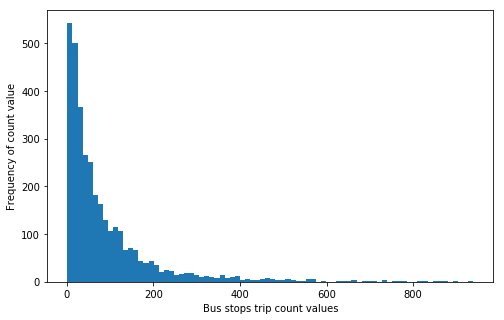

In [68]:
#plot histogram of the exit trips
ax = dest_summary['TripsPerdest'].plot.hist(bins = 80, figsize=(8,5))
ax.set_xlabel('Bus stops trip count values')
ax.set_ylabel('Frequency of count value')

In [69]:
df_allpoi = dest_summary[['dest_busid', 'TripsPerdest', 'all_poi_100','all_poi_200','all_poi_300','all_poi_400','all_poi_500','all_poi_600']].copy()

In [70]:
df_access_scores = dest_summary[['dest_busid', 'TripsPerdest', 'access_score_100', 'access_score_200', 'access_score_300',  'access_score_400', 'access_score_500', 'access_score_600']].copy()

In [84]:
df_allpoi = dest_summary[['TripsPerdest','all_poi_100','all_poi_200','all_poi_300','all_poi_400','all_poi_500','all_poi_600']].copy()
df_buffers = df_allpoi.copy()

In [85]:
df_buffers.sort_values(by=['TripsPerdest'], inplace=True)
df_buffers = df_buffers.reset_index()

In [88]:
#checking to see if low trips have pois for different buffers
onetrip = df_buffers[df_buffers.TripsPerdest < 100]
print(len(onetrip))
#onetrip.loc[onetrip.isnull().any(axis=1)]
len(onetrip[onetrip['all_poi_400'].isnull()])

2444


507

In [98]:
#df_buffers['all_poi_100']

In [89]:
df_buffers[['all_poi_100','all_poi_200', 'all_poi_300', 'all_poi_400', 'all_poi_500', 'all_poi_600']] = df_buffers[['all_poi_100',
       'all_poi_200', 'all_poi_300', 'all_poi_400', 'all_poi_500',
       'all_poi_600']].fillna(0)

In [91]:
df_buffers['poiBuffer_100'] = df_buffers.all_poi_100
df_buffers['poiBuffer_200'] = df_buffers.all_poi_200 - df_buffers.all_poi_100
df_buffers['poiBuffer_300'] = df_buffers.all_poi_300 - df_buffers.all_poi_200
df_buffers['poiBuffer_400'] = df_buffers.all_poi_400 - df_buffers.all_poi_300
df_buffers['poiBuffer_500'] = df_buffers.all_poi_500 - df_buffers.all_poi_400
df_buffers['poiBuffer_600'] = df_buffers.all_poi_600 - df_buffers.all_poi_500

In [93]:
#df_access_scores.astype(bool).sum(axis=0)
df_buffers.astype(bool).sum(axis=0)

index            3427
TripsPerdest     3428
all_poi_100       390
all_poi_200      1329
all_poi_300      2289
all_poi_400      2849
all_poi_500      3232
all_poi_600      3428
poiBuffer_100     390
poiBuffer_200    1101
poiBuffer_300    1694
poiBuffer_400    2026
poiBuffer_500    2340
poiBuffer_600    2536
dtype: int64

In [94]:
df_buffers.columns

Index(['index', 'TripsPerdest', 'all_poi_100', 'all_poi_200', 'all_poi_300',
       'all_poi_400', 'all_poi_500', 'all_poi_600', 'poiBuffer_100',
       'poiBuffer_200', 'poiBuffer_300', 'poiBuffer_400', 'poiBuffer_500',
       'poiBuffer_600'],
      dtype='object')

In [110]:
#cluster analysis

In [225]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as sm
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report

In [112]:
from mpl_toolkits.mplot3d import Axes3D

In [114]:
#set ploting parameters for data visualization
#%matplotlib inline
#rcParams['figure.figsize'] = 7,4

In [116]:
df_buffers.head()

,index,dest_busid,TripsPerdest,TripsPerOrig,all_poi_100,all_poi_200,all_poi_300,all_poi_400,all_poi_500,all_poi_600,poiBuffer_100,poiBuffer_200,poiBuffer_300,poiBuffer_400,poiBuffer_500,poiBuffer_600
0,3677,5281,1,6.0,0.0,0.0,1.0,3.0,3.0,4.0,0.0,0.0,1.0,2.0,0.0,1.0
1,1016,2238,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1017,2240,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1019,2244,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1869,3274,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
#set what rows and columns you want included in the clustering
#for dest trips and all_poi100 
X = df_buffers.iloc[:,[2,13]].values

In [160]:
#how many clusters do we want to generate
#check from shape of data and find number of optimal custers
#keep sum of squared values in an array
wcss = []

#run for 15 clusters
for i in range(1,16):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state = 5)
    #fit data using the kmeans variable
    kmeans.fit(X)
    #extract the sum of squared errors
    wcss.append(kmeans.inertia_)

In [161]:
#wcss

<function matplotlib.pyplot.show(*args, **kw)>

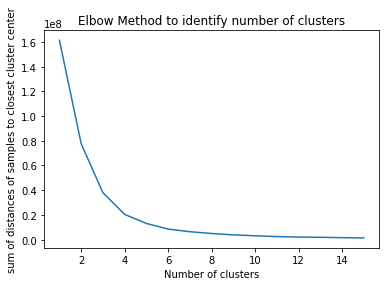

In [163]:
#visualize to make decisions for the k
plt.plot(range(1,16), wcss)
plt.title('Elbow Method to identify number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('sum of distances of samples to closest cluster center')
plt.show

In [ ]:
#The number of clusters should be 4 based on the elbow

In [212]:
kmeans = KMeans(n_clusters=4, init = 'k-means++',random_state=5)

In [213]:
#generate value of y to show which instance belongs to the clusters
y =kmeans.fit_predict(X)

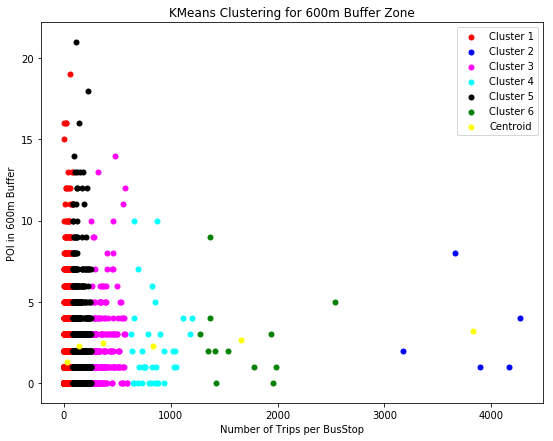

In [224]:
#set what rows and columns you want included in the clustering
X = df_buffers.iloc[:,[2,15]].values

#run the analysis
kmeans = KMeans(n_clusters=6, init = 'k-means++',random_state=5)

#generate value of y to show which instance belongs to the clusters
y =kmeans.fit_predict(X)

#make y easy to read through visualization using scatter. We have X and we are trying to fetch according to index of X and y
plt.figure(figsize=(9,7))
plt.scatter(X[y == 0,0], X[y==0,1], s = 25, c='red', label='Cluster 1')
plt.scatter(X[y == 1,0], X[y==1,1], s = 25, c='blue', label='Cluster 2')
plt.scatter(X[y == 2,0], X[y==2,1], s = 25, c='magenta', label='Cluster 3')
plt.scatter(X[y == 3,0], X[y==3,1], s = 25, c='cyan', label='Cluster 4')
plt.scatter(X[y == 4,0], X[y==4,1], s = 25, c='black', label='Cluster 5')
plt.scatter(X[y == 5,0], X[y==5,1], s = 25, c='green', label='Cluster 6')



plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=25, c='yellow', label='Centroid')
plt.title('KMeans Clustering for 600m Buffer Zone')
plt.xlabel('Number of Trips per BusStop')
plt.ylabel('POI in 600m Buffer')

plt.legend()
plt.show()

In [201]:
len(df_DestBus600.poi.unique())

2183

In [229]:
#normailizing the values because of the extreme values present
X = df_buffers.iloc[:,[2,15]].values
norm_data = MinMaxScaler() #initialize the values to 1 and the weights have not changed
X=norm_data.fit_transform(X)

<function matplotlib.pyplot.show(*args, **kw)>

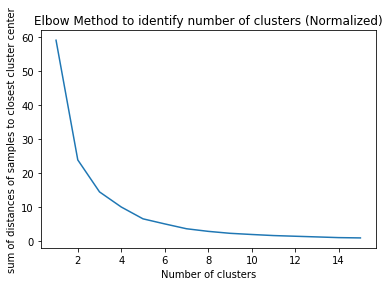

In [230]:
#how many clusters do we want to generate
#check from shape of data and find number of optimal custers
#keep sum of squared values in an array
wcss = []

#run for 15 clusters
for i in range(1,16):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state = 5)
    #fit data using the kmeans variable
    kmeans.fit(X)
    #extract the sum of squared errors
    wcss.append(kmeans.inertia_)
    
#visualize to make decisions for the k
plt.plot(range(1,16), wcss)
plt.title('Elbow Method to identify number of clusters (Normalized)')
plt.xlabel('Number of clusters')
plt.ylabel('sum of distances of samples to closest cluster center')
plt.show

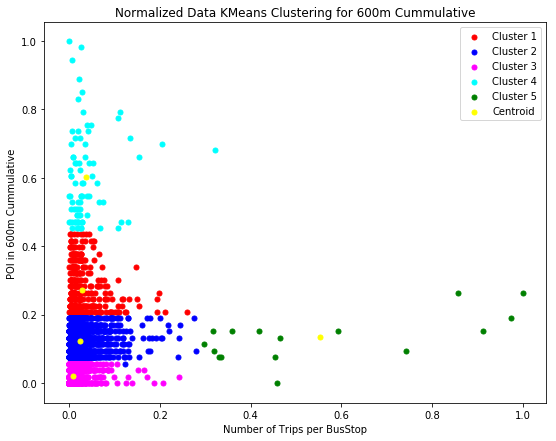

In [241]:
#normailizing the values because of the extreme values present
X = df_buffers.iloc[:,[2,9]].values
norm_data = MinMaxScaler() #initialize the values to 1 and the weights have not changed
X=norm_data.fit_transform(X)
#run the analysis
kmeans = KMeans(n_clusters=5, init = 'k-means++',random_state=5)

#generate value of y to show which instance belongs to the clusters
y =kmeans.fit_predict(X)

#make y easy to read through visualization using scatter. We have X and we are trying to fetch according to index of X and y
plt.figure(figsize=(9,7))
plt.scatter(X[y == 0,0], X[y==0,1], s = 25, c='red', label='Cluster 1')
plt.scatter(X[y == 1,0], X[y==1,1], s = 25, c='blue', label='Cluster 2')
plt.scatter(X[y == 2,0], X[y==2,1], s = 25, c='magenta', label='Cluster 3')
plt.scatter(X[y == 3,0], X[y==3,1], s = 25, c='cyan', label='Cluster 4')
plt.scatter(X[y == 4,0], X[y==4,1], s = 25, c='green', label='Cluster 5')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=25, c='yellow', label='Centroid')
plt.title('Normalized Data KMeans Clustering for 600m Cummulative')
plt.xlabel('Number of Trips per BusStop')
plt.ylabel('POI in 600m Cummulative')

plt.legend()
plt.show()

In [242]:
#find target label associated with each cluster class
#first find unique values of clusters
cluster_labels = np.unique(y)

In [243]:
for index in cluster_labels:

array([1, 2, 2, ..., 4, 4, 4])